<a href="https://colab.research.google.com/github/SalimJarmakani/custom-cnn-vision/blob/main/CustomCNN_8610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import layers, regularizers
import numpy as np, time, pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download muhammadrehan00/chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset
License(s): CC-BY-NC-SA-4.0
 98% 3.00G/3.05G [00:06<00:00, 404MB/s]
100% 3.05G/3.05G [00:06<00:00, 472MB/s]


In [ ]:
import zipfile
import os

# Paths
zip_file_path = '/content/chest-xray-dataset.zip'
destination_dir = '/content/dataset'

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Check if dataset already extracted
expected_subdirs = ['train', 'val', 'test']
already_unzipped = all(os.path.exists(os.path.join(destination_dir, sub)) for sub in expected_subdirs)

if already_unzipped:
    print(f"Dataset already unzipped in: {destination_dir}")
else:
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)
    print(f"Dataset successfully unzipped to: {destination_dir}")

Unzipping dataset...
Dataset successfully unzipped to: /content/dataset


In [ ]:
import tensorflow as tf


data_dir = '/content/dataset/'

# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create training, validation, and test datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'val',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 20450 files belonging to 3 classes.
Found 2534 files belonging to 3 classes.
Found 2569 files belonging to 3 classes.
Classes: ['normal', 'pneumonia', 'tuberculosis']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Extract class counts from train_ds
y_train_all = []
for _, y in train_ds:
    y_train_all.append(np.argmax(y.numpy(), axis=1))
y_train_all = np.concatenate(y_train_all)

# Step 2: Compute class weights automatically
classes = np.arange(len(class_names))
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_all
)
class_weights = {i: w for i, w in enumerate(weights)}
print("\n Computed class weights:", class_weights)


 Computed class weights: {0: np.float64(0.9385469732433797), 1: np.float64(1.4584224789616318), 2: np.float64(0.8007361290575199)}


In [ ]:
    # Add learning-rate scheduler, noticed drops in validation accuracy after a certain point
def scheduler(epoch, lr):
  if epoch < 4:
    return lr  # warmup phase
  else:
    return lr * 0.3 # gentle decay

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

IndentationError: expected an indented block after 'if' statement on line 3 (ipython-input-2392402226.py, line 4)

In [ ]:
def conv_bn_act(x, filters, k=3, s=1, wd=1e-5):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def dw_sep_block(x, filters, s=1, expand=1.0, wd=1e-5):
    in_ch = x.shape[-1]
    hidden = max(int(in_ch * expand), int(in_ch))

    if expand != 1.0:
        x = conv_bn_act(x, hidden, k=1, s=1, wd=wd)

    y = layers.DepthwiseConv2D(3, strides=s, padding="same", use_bias=False,
                               depthwise_regularizer=regularizers.l2(wd))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    # lightweight Squeeze-Excitation
    se = layers.GlobalAveragePooling2D()(y)
    se = layers.Dense(max(hidden // 8, 8), activation="relu")(se)
    se = Dense(int(y.shape[-1]), activation="sigmoid")(se)
    se = layers.Reshape((1,1,hidden))(se)
    y = layers.Multiply()([y, se])

    y = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(y)
    y = layers.BatchNormalization()(y)

    if (s == 1) and (int(in_ch) == int(filters)):
        y = layers.Add()([y, x])
    return layers.ReLU()(y)

def build_custom_cnn(input_shape=(224,224,3), num_classes=3, wd=1e-5, drop=0.4, filter_scale=1.0):

    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    # #Mild X-ray-safe augmentation
    # x = tf.keras.Sequential([
    #     tf.keras.layers.RandomFlip("horizontal"),
    #     tf.keras.layers.RandomRotation(0.1),
    #     tf.keras.layers.RandomZoom(0.1),
    #  ], name="xray_aug")(x)

    def conv_bn_act(x, filters, k=3, s=1, wd=1e-5):
        x = layers.Conv2D(int(filters*filter_scale), k, strides=s, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(wd))(x)
        x = layers.BatchNormalization()(x)
        return layers.ReLU()(x)

    def dw_sep_block(x, filters, s=1, expand=1.0, wd=1e-5):
        in_ch = x.shape[-1]
        hidden = max(int(in_ch * expand), int(in_ch))
        filters_scaled = int(filters * filter_scale)
        if expand != 1.0:
            x = conv_bn_act(x, hidden, k=1, s=1, wd=wd)

        y = layers.DepthwiseConv2D(3, strides=s, padding="same", use_bias=False,
                                   depthwise_regularizer=regularizers.l2(wd))(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)

        se = layers.GlobalAveragePooling2D()(y)
        se = layers.Dense(max(int(y.shape[-1]) // 8, 8), activation="relu")(se)
        se = layers.Dense(int(y.shape[-1]), activation="sigmoid")(se)
        se = layers.Reshape((1, 1, int(y.shape[-1])))(se)
        y = layers.Multiply()([y, se])

        y = layers.Conv2D(filters_scaled, 1, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(wd))(y)
        y = layers.BatchNormalization()(y)

        if (s == 1) and (int(in_ch) == filters_scaled):
            y = layers.Add()([y, x])
        return layers.ReLU()(y)

    # Stem
    x = conv_bn_act(x, 32, 3, 2, wd)
    x = conv_bn_act(x, 64, 3, 1, wd)
    x = layers.MaxPooling2D()(x)

    # Depthwise blocks
    x = dw_sep_block(x, 96, 1, 1.2, wd)
    x = dw_sep_block(x, 160, 2, 1.2, wd)
    x = dw_sep_block(x, 224, 2, 1.2, wd)
    x = dw_sep_block(x, 288, 2, 1.25, wd)

    #new layer
    x = dw_sep_block(x, 352, 2, 1.25, wd)
    x = dw_sep_block(x, 416, 2, 1.3, wd)    #second extra block
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(drop)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name=f"CustomCNN_scale{filter_scale}")
    return model


# --- Build and compile ---
custom_model = build_custom_cnn(input_shape=(img_height,img_width,3), num_classes=len(class_names))
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
    metrics=["accuracy"]
)
custom_model.summary()

Model: "CustomCNN_scale1.0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,432 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      4,864 │ max_pooling2d[0]… │
│                     │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        304 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 56, 56,    │        684 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        304 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 76)        │          0 │ re_lu_3[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9)         │        693 │ global_average_p

 Total params: 1,011,865 (3.86 MB)

 Trainable params: 1,002,681 (3.82 MB)

 Non-trainable params: 9,184 (35.88 KB)

In [ ]:
# Improved Custom CNN Training: Safe Augmentation + Focal Loss + Class Weights + Val-Loss Early Stop
import tensorflow as tf, numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

# --- Safe X-ray-compatible augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # safe for chest X-rays
    layers.RandomRotation(0.05),            # ±5% small rotation
    layers.RandomZoom(0.1),                 # small zoom-in/out
    layers.RandomTranslation(0.05, 0.05)    # gentle shift
], name="xray_safe_aug")

# integrate into model
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# --- reuse custom CNN blocks ---
def conv_bn_act(x, filters, k=3, s=1, wd=1e-5):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False,
                      kernel_regularizer=tf.keras.regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def dw_sep_block(x, filters, s=1, expand=1.0, wd=1e-5):
    in_ch = x.shape[-1]
    hidden = max(int(in_ch * expand), int(in_ch))

    if expand != 1.0:
        x = conv_bn_act(x, hidden, k=1, s=1, wd=wd)

    y = layers.DepthwiseConv2D(3, strides=s, padding="same", use_bias=False,
                               depthwise_regularizer=tf.keras.regularizers.l2(wd))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    se = layers.GlobalAveragePooling2D()(y)
    se = layers.Dense(max(hidden // 8, 8), activation="relu")(se)
    se = layers.Dense(int(y.shape[-1]), activation="sigmoid")(se)
    se = layers.Reshape((1, 1, hidden))(se)
    y = layers.Multiply()([y, se])

    y = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                      kernel_regularizer=tf.keras.regularizers.l2(wd))(y)
    y = layers.BatchNormalization()(y)

    if (s == 1) and (int(in_ch) == int(filters)):
        y = layers.Add()([y, x])
    return layers.ReLU()(y)

# --- Build network body ---
x = conv_bn_act(x, 32, 3, 2)
x = conv_bn_act(x, 64, 3, 1)
x = layers.MaxPooling2D()(x)

x = dw_sep_block(x, 96, 1, 1.2)
x = dw_sep_block(x, 160, 2, 1.2)
x = dw_sep_block(x, 224, 2, 1.2)
x = dw_sep_block(x, 288, 2, 1.25)
x = dw_sep_block(x, 352, 2, 1.25)
x = dw_sep_block(x, 416, 2, 1.3)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

custom_model = tf.keras.Model(inputs, outputs, name="CustomCNN_Augmented")

# --- Focal Loss ---
alphas = np.array([class_weights[i] for i in range(len(class_names))], dtype="float32")
alphas = alphas / alphas.sum()

def categorical_focal_loss(alpha, gamma=1.8):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal = tf.pow(1. - p_t, gamma) * ce
        alpha_t = tf.reduce_sum(y_true * alpha, axis=-1)
        return alpha_t * focal
    return loss


# --- Compile with early stopping based on val_loss ---
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=categorical_focal_loss(alphas, gamma=1.8),
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    "best_val_model.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)


# --- Train ---
history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)


Epoch 1/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5887 - loss: 0.1530
Epoch 1: val_loss improved from inf to 0.13693, saving model to best_val_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - accuracy: 0.5888 - loss: 0.1530 - val_accuracy: 0.5635 - val_loss: 0.1369
Epoch 2/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7035 - loss: 0.0897
Epoch 2: val_loss improved from 0.13693 to 0.13244, saving model to best_val_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 67s 105ms/step - accuracy: 0.7035 - loss: 0.0897 - val_accuracy: 0.6290 - val_loss: 0.1324
Epoch 3/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7239 - loss: 0.0797
Epoch 3: val_loss improved from 0.13244 to 0.09543, saving model to best_val_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 67s 105ms/step - accuracy: 0.7239 - loss: 0.0797 - val_accuracy: 0.6811 - val_loss: 0.0954
Epoch 4/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7388 - loss: 0.0769
Epoch 4: val_loss did not imp

In [ ]:
# Re-train with focal loss
import tensorflow as tf, numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 1) Use UNIFORM alpha
n_classes = len(class_names)
alphas = np.ones(n_classes, dtype="float32") / n_classes

def categorical_focal_loss(alpha, gamma=1.4):  # slightly gentler focusing
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal = tf.pow(1. - p_t, gamma) * ce
        alpha_t = tf.reduce_sum(y_true * alpha, axis=-1)
        return alpha_t * focal
    return loss

# --- 2) Compile with the new focal loss (NO class_weight in fit) ---
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=categorical_focal_loss(alphas, gamma=1.4),
    metrics=["accuracy"]
)

# --- 3) Callbacks:
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1
)
checkpoint_cb = ModelCheckpoint(
    "best_val_model.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1
)
lr_callback = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- 4) Train (note: NO class_weight here) ---
history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint_cb, lr_callback],
    verbose=1
)


Epoch 1/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7478 - loss: 0.0784
Epoch 1: val_loss improved from inf to 0.07675, saving model to best_val_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - accuracy: 0.7478 - loss: 0.0784 - val_accuracy: 0.7534 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 2/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7479 - loss: 0.0797
Epoch 2: val_loss did not improve from 0.07675
640/640 ━━━━━━━━━━━━━━━━━━━━ 67s 105ms/step - accuracy: 0.7479 - loss: 0.0797 - val_accuracy: 0.6725 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 3/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7451 - loss: 0.0768
Epoch 3: val_loss improved from 0.07675 to 0.07270, saving model to best_val_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 68s 106ms/step - accuracy: 0.7451 - loss: 0.0768 - val_accuracy: 0.7605 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 4/30
639/640 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7507 - loss: 0.07

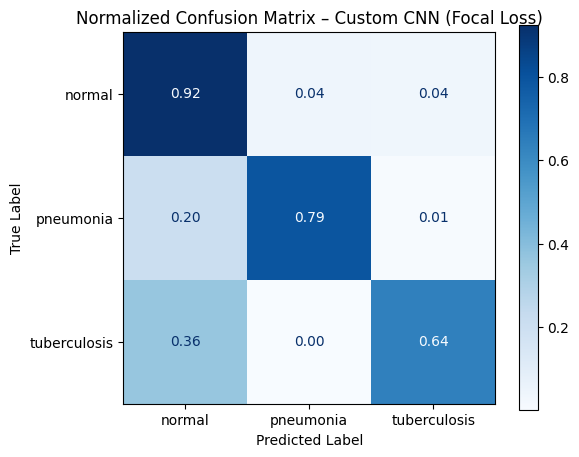


Classification Report:
              precision    recall  f1-score   support

      normal     0.6293    0.9232    0.7485       925
   pneumonia     0.9217    0.7914    0.8516       580
tuberculosis     0.9496    0.6372    0.7627      1064

    accuracy                         0.7750      2569
   macro avg     0.8335    0.7839    0.7876      2569
weighted avg     0.8280    0.7750    0.7776      2569


✅ Test Accuracy: 77.50%


In [ ]:
# Evaluate Custom CNN: Normalized Confusion Matrix + Metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Load best model ---
model_path = "/content/focal/CustomCNN_Focal.keras"
best_model = tf.keras.models.load_model(model_path, compile=False)

# --- Collect predictions on the test set ---
y_true, y_pred = [], []
for x, y in test_ds:
    preds = best_model.predict(x, verbose=0)
    y_true.append(np.argmax(y.numpy(), axis=1))   # convert one-hot to class index
    y_pred.append(np.argmax(preds, axis=1))       # predicted class index

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- Compute normalized confusion matrix ---
cm = confusion_matrix(y_true, y_pred, normalize='true')  # row-normalized (each row sums to 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# ---Plot normalized matrix ---
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format=".2f", ax=plt.gca(), colorbar=True)
plt.title("Normalized Confusion Matrix – Custom CNN (Focal Loss)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- Print detailed metrics ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# --- Test accuracy summary ---
test_acc = np.mean(y_true == y_pred)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


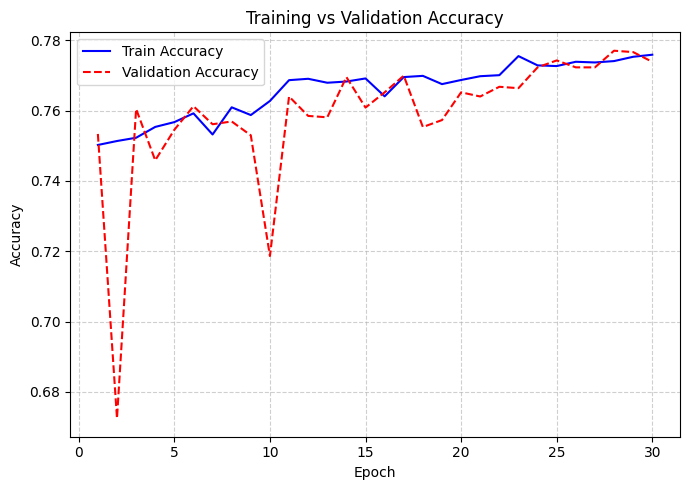

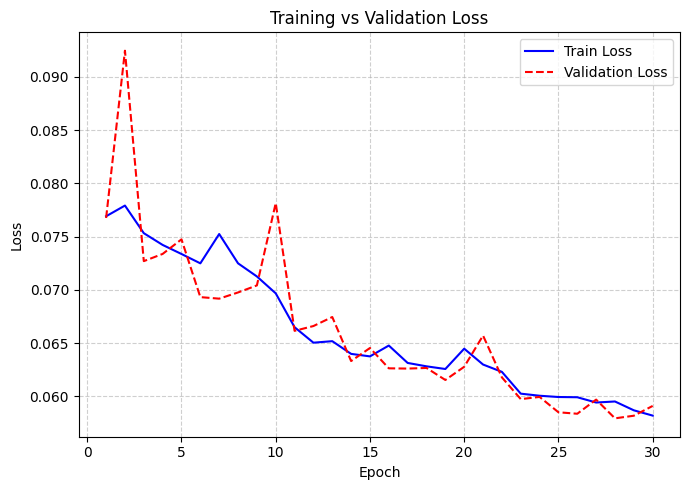

⚠️ No 'lr' key in history — skipping learning rate plot.


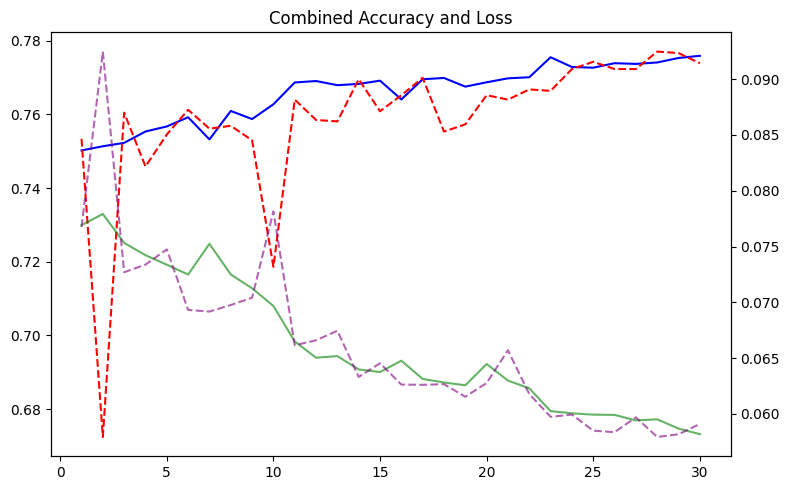

✅ All history plots saved to directory: history_plots/


In [ ]:
# Save Separate Training History Plots
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Create directory ---
os.makedirs("history_plots", exist_ok=True)

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.style.use("seaborn-v0_8-muted")

# --- Accuracy Plot ---
plt.figure(figsize=(7,5))
plt.plot(epochs, hist["accuracy"], label="Train Accuracy", color="blue")
if "val_accuracy" in hist:
    plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy", color="red", linestyle="--")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("history_plots/accuracy.png", dpi=300)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(7,5))
plt.plot(epochs, hist["loss"], label="Train Loss", color="blue")
if "val_loss" in hist:
    plt.plot(epochs, hist["val_loss"], label="Validation Loss", color="red", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("history_plots/loss.png", dpi=300)
plt.show()

# --- Learning Rate Plot
if "lr" in hist:
    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["lr"], label="Learning Rate", color="green")
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig("history_plots/learning_rate.png", dpi=300)
    plt.show()
else:
    print("No 'lr' key in history — skipping learning rate plot.")

# --- Combined Plot ---
plt.figure(figsize=(8,5))
plt.plot(epochs, hist["accuracy"], label="Train Accuracy", color="blue")
if "val_accuracy" in hist:
    plt.plot(epochs, hist["val_accuracy"], label="Val Accuracy", color="red", linestyle="--")

plt.twinx()
plt.plot(epochs, hist["loss"], label="Train Loss", color="green", alpha=0.6)
if "val_loss" in hist:
    plt.plot(epochs, hist["val_loss"], label="Val Loss", color="purple", linestyle="--", alpha=0.6)

plt.title("Combined Accuracy and Loss")
plt.xlabel("Epoch")
plt.tight_layout()
plt.savefig("history_plots/combined.png", dpi=300)
plt.show()

print("All history plots saved to directory: history_plots/")


In [ ]:
# Evaluate trained Custom CNN on the test dataset
from sklearn.metrics import f1_score
import numpy as np

# --- Load the saved focal model ---
model_path = "/content/focal/CustomCNN_Focal.keras"
cell_model = tf.keras.models.load_model(model_path, compile=False)
def evaluate_model(model, test_ds):
    y_true, y_pred = [], []
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_true.append(np.argmax(y, axis=1))           # one-hot → class index
        y_pred.append(np.argmax(preds, axis=1))       # predicted class index
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = np.mean(y_true == y_pred)
    return acc, f1

# --- Run evaluation ---
acc, f1 = evaluate_model(cell_model, test_ds)

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Weighted F1 Score: {f1*100:.2f}")


✅ Test Accuracy: 77.50%
🎯 Weighted F1 Score: 77.76


ROC–AUC plot saved to: /content/ROC_CustomCNN.png


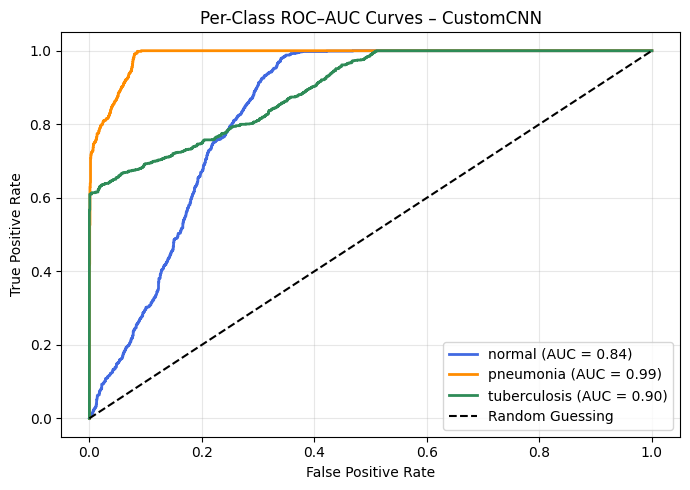


Macro-average ROC–AUC: 0.908


In [ ]:
# ===============================
# Multi-Class ROC–AUC Evaluation for Custom CNN
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

def multiclass_roc_auc_score(model, test_ds, class_labels, average="macro", save_path=None):
    """
    Compute and plot ROC–AUC curves for each class in a multi-class setting.
    Returns the macro-average ROC–AUC score.
    """

    # Extract true labels
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Get predictions (probabilities for each class)
    y_pred = model.predict(test_ds, verbose=0)

    # Binarize true labels
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

    # Compute ROC and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for idx, label in enumerate(class_labels):
        fpr[idx], tpr[idx], _ = roc_curve(y_true_bin[:, idx].astype(int), y_pred[:, idx])
        roc_auc[idx] = auc(fpr[idx], tpr[idx])

    # Plot ROC curves
    plt.figure(figsize=(7, 5))
    colors = ['royalblue', 'darkorange', 'seagreen']

    for idx, color in zip(range(len(class_labels)), colors):
        plt.plot(fpr[idx], tpr[idx], color=color, lw=2,
                 label=f"{class_labels[idx]} (AUC = {roc_auc[idx]:.2f})")

    # Random baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guessing')

    # Labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-Class ROC–AUC Curves – CustomCNN')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # save the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC–AUC plot saved to: {save_path}")

    plt.show()

    # Compute and return macro-average ROC–AUC
    macro_auc = roc_auc_score(y_true_bin, y_pred, average=average)
    print(f"\nMacro-average ROC–AUC: {macro_auc:.3f}")
    return macro_auc


# ===============================
# Run the ROC–AUC evaluation
# ===============================
class_labels = test_ds.class_names  # e.g. ['Normal', 'Pneumonia', 'Tuberculosis']

macro_auc = multiclass_roc_auc_score(
    model=cell_model,
    test_ds=test_ds,
    class_labels=class_labels,
    average="macro",
    save_path="/content/ROC_CustomCNN.png"
)


In [ ]:
# ===============================
# Load Focal Model & Evaluate
# ===============================
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

# --- Load saved focal loss model ---
model_path = "/content/focal/CustomCNN_Focal.keras"
focal_model = tf.keras.models.load_model(model_path, compile=False)
print(f"Loaded model from: {model_path}")

# --- Define evaluation function (from before) ---
def evaluate_model(model, test_ds):
    y_true, y_pred = [], []
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_true.append(np.argmax(y, axis=1))
        y_pred.append(np.argmax(preds, axis=1))
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = np.mean(y_true == y_pred)
    return acc, f1

# --- Evaluate focal model ---
acc, f1 = evaluate_model(focal_model, test_ds)

print(f"\n Test Accuracy: {acc*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")


✅ Loaded model from: /content/focal/CustomCNN_Focal.keras

✅ Test Accuracy: 77.50%
🎯 Weighted F1 Score: 0.7776
